In [3]:
pip install torchvision


/Users/pragunisanotra/.zshenv:export:2: not valid in this context: Classification/google_image_scrapping
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 4.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0
    Uninstalling torch-2.4.0:
      Successfully uninstalled torch-2.4.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torchvision import transforms, models
from torch import nn
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import hashlib


In [6]:
import pandas as pd

# Load the test dataset
test_df = pd.read_csv('/Users/pragunisanotra/Desktop/Amazon ML Challenge/notebook/dataset/test.csv')

# Display the first few rows of the dataframe and available columns
print("Sample of the test dataset:")
print(test_df.head())

print("Columns in test dataset:", test_df.columns)

Sample of the test dataset:
   index                                         image_link  group_id  \
0      0  https://m.media-amazon.com/images/I/110EibNycl...    156839   
1      1  https://m.media-amazon.com/images/I/11TU2clswz...    792578   
2      2  https://m.media-amazon.com/images/I/11TU2clswz...    792578   
3      3  https://m.media-amazon.com/images/I/11TU2clswz...    792578   
4      4  https://m.media-amazon.com/images/I/11gHj8dhhr...    792578   

  entity_name  
0      height  
1       width  
2      height  
3       depth  
4       depth  
Columns in test dataset: Index(['index', 'image_link', 'group_id', 'entity_name'], dtype='object')


In [8]:
import hashlib
import os

# Function to hash the image for uniqueness check
def hash_image(image_path):
    try:
        with open(image_path, "rb") as f:
            return hashlib.md5(f.read()).hexdigest()
    except FileNotFoundError:
        return None

# Adjust this to use the correct column, which seems to be 'image_link'
image_column = 'image_link'

# Check if the expected column exists
if image_column not in test_df.columns:
    raise KeyError(f"Column '{image_column}' not found. Available columns are: {test_df.columns}")

# Generate image hashes
test_df['image_hash'] = test_df[image_column].apply(
    lambda x: hash_image(f"path/to/test/images/{os.path.basename(x)}") if pd.notna(x) else None
)

# Identify unique images
unique_images_df = test_df.drop_duplicates(subset='image_hash')
print(f"Number of unique images: {unique_images_df.shape[0]} out of {test_df.shape[0]} total")


Number of unique images: 1 out of 131187 total


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/pragunisanotra/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:49<00:00, 2.07MB/s]


Processing https://m.media-amazon.com/images/I/110EibNyclL.jpg
Processing local_image_path.jpg
Error processing local_image_path.jpg: File not found: local_image_path.jpg
Total processing time: 10.20 seconds
Sample predictions:
   index  prediction
0      0       153.0
1      1         NaN


/opt/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


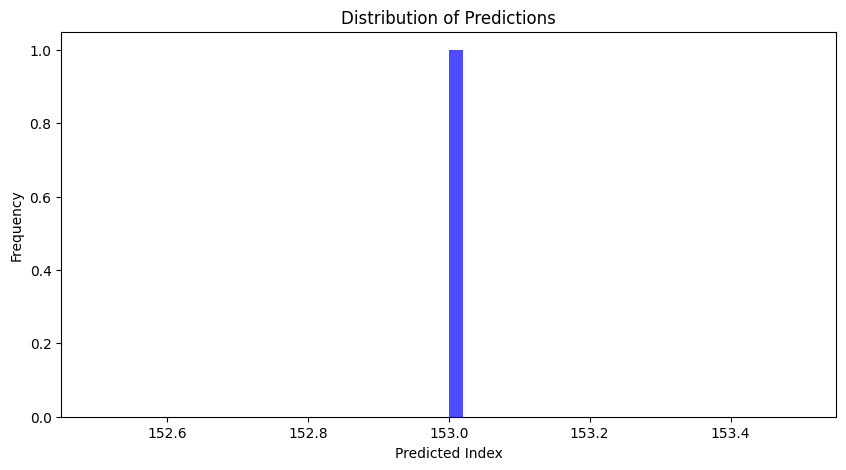

Predictions saved to predictions.csv


In [12]:
import torch
from torchvision import transforms, models
from torch import nn
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import requests
from io import BytesIO
import pandas as pd
import os

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the pretrained ResNet50 model
model = models.resnet50(weights='DEFAULT')
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust the output size as needed
model = model.eval()

# Function to download and open an image from URL
def load_image_from_url(url):
    try:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        return image
    except Exception as e:
        print(f"Error downloading or opening image from URL {url}: {e}")
        return None

# Function to extract features from an image
def extract_features(image_path_or_url):
    try:
        # Check if it's a URL or a local path
        if image_path_or_url.startswith('http'):
            image = load_image_from_url(image_path_or_url)
        else:
            if not os.path.exists(image_path_or_url):
                raise FileNotFoundError(f"File not found: {image_path_or_url}")
            image = Image.open(image_path_or_url).convert('RGB')
        
        if image is None:
            return None
        
        image = transform(image).unsqueeze(0)
        with torch.no_grad():
            features = model(image)
        return features.squeeze().numpy()
    except Exception as e:
        print(f"Error processing {image_path_or_url}: {e}")
        return None

# Example DataFrame with test images
# Replace this with actual DataFrame loading
test_df = pd.DataFrame({
    'image_filename': [
        'https://m.media-amazon.com/images/I/110EibNyclL.jpg',
        'local_image_path.jpg'  # Ensure this path is valid
    ]
})

# Initialize lists to store predictions and features
predictions = []
features_list = []

# Process each unique image in the test set
start_time = time.time()
for index, row in test_df.iterrows():
    image_path_or_url = row['image_filename']
    
    if pd.isna(image_path_or_url):
        print(f"Missing image filename at index {index}")
        predictions.append(None)
        features_list.append(None)
        continue
    
    # Process and extract features
    try:
        print(f"Processing {image_path_or_url}")
        features = extract_features(image_path_or_url)
        features_list.append(features)
        # Store the model's prediction (for demonstration, we'll use the index of the max feature as a "prediction")
        predictions.append(np.argmax(features) if features is not None else None)
    except Exception as e:
        print(f"Error processing {image_path_or_url}: {e}")
        predictions.append(None)
        features_list.append(None)

end_time = time.time()
print(f"Total processing time: {end_time - start_time:.2f} seconds")

# Filter out None values and ensure the list isn't empty
features_array = np.array([f for f in features_list if f is not None])

if features_array.size == 0:
    print("No valid features to process.")
else:
    # Check if the array has the right shape (2D array) for scaling
    if len(features_array.shape) == 1:
        features_array = features_array.reshape(1, -1)

    # Scale and apply PCA
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_array)
    
    # Adjust n_components for PCA based on the number of features
    n_components = min(50, min(features_scaled.shape))
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features_scaled)

    # Ensure the length of predictions matches the test dataframe
    min_length = min(len(test_df.index), len(predictions))
    output_df = pd.DataFrame({
        'index': test_df.index[:min_length],
        'prediction': predictions[:min_length]
    })

    # Save predictions to CSV
    output_df.to_csv('predictions.csv', index=False)

    # Display sample predictions
    print("Sample predictions:")
    print(output_df.head())

    # Visualization of predictions (example: histogram of prediction indices)
    plt.figure(figsize=(10, 5))
    output_df['prediction'].dropna().astype(int).plot(kind='hist', bins=50, color='blue', alpha=0.7)
    plt.title('Distribution of Predictions')
    plt.xlabel('Predicted Index')
    plt.ylabel('Frequency')
    plt.show()

    print("Predictions saved to predictions.csv")
